In [2]:
import pywph as pw
import numpy as np
import torch
import torch.utils.data as data_utils
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso
import sklearn
import matplotlib.pyplot as plt
# Device Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from statsmodels.multivariate.cancorr import CanCorr as CCA

# Dark matter only simulations

In [2]:
import scipy
def getLinearCoef(coef,param):
    r = []
    for i in range(coef.shape[1]):
        r.append(scipy.stats.pearsonr(coef[:,i], param)[0])
    return np.array(r)

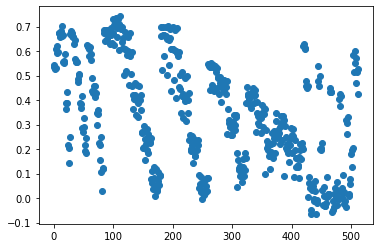

In [15]:
coef   = np.load("../data/wph_dmo_for_regression.npy")
r = getLinearCoef(np.real(coef),params)
plt.scatter(range(r.shape[0]),r)

/mnt/sw/nix/store/z6v265ivx5w6xbajay41vdfc0la8gla5-python-3.9.12-view/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


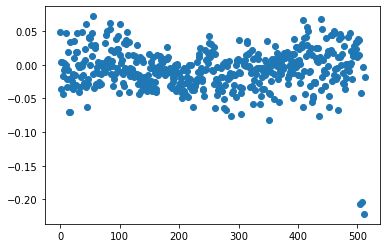

In [16]:
r = getLinearCoef(np.imag(coef),params)
plt.scatter(range(r.shape[0]),r)

# CCA 

## CCA code

In [30]:
import numpy as np
def CCA(x, y, thres=1e-10):
    # x be (n,p1)
    # y be (n,p2)

    n, p1 = x.shape
    n, p2 = y.shape

    # SVD
    u1, s1, vt1 = np.linalg.svd(x ,full_matrices=False)
    u2, s2, vt2 = np.linalg.svd(y ,full_matrices=False)

    d1 = np.sum(s1 > thres) # d1 == p1 if x is non-degen
    d2 = np.sum(s2 > thres) # d2 == p2 if y is non-degen
    
    sinv1 = 1/s1
    sinv2 = 1/s2
    #print(sinv1, sinv2)

    xtotvar = np.sum(np.power(s1,2))
    ytotvar = np.sum(np.power(s2,2))

    q = np.matmul(u1.T[:d1,:], u2[:,:d2]) # maybe wrong
    
    uq, sq, vtq = np.linalg.svd(q,full_matrices=False)
    #print(uq.shape, sq.shape, vtq.shape)
    
    d = min(d1, d2)
    xccvar = np.matmul(np.eye(d1)*s1[:d1],u1[:d1,:d])/xtotvar
    yccvar = np.matmul(np.eye(d2)*s2[:d2].T,u2[:d2,:d])/ytotvar

    a = np.matmul(vt1.T[:p1,:d1],np.matmul(np.eye(d1)*sinv1,uq[:d1,:d]))
    b = np.matmul(vt2.T[:p2,:d2],np.matmul(np.eye(d2)*sinv2,vtq.T[:d2,:d]))
    #print(a.shape,b.shape)
    
    r = np.maximum(np.minimum(1,sq),0)
    xexplvar = xccvar * r**2
    yexplvar = yccvar * r**2

    # normalize a and b (do we need this?)
    a = a * np.sqrt(n-1)
    b = b * np.sqrt(n-1)

    u = np.matmul(x,a)
    v = np.matmul(y,b)
    
    return a, b, u, v

## CCA to DMO

In [14]:
fparam = "/mnt/ceph/users/fvillaescusa/Nbody_systematics/data/maps/maps_Gadget/params_Gadget.txt"
gparams = np.loadtxt(fparam)
gparams = gparams[:,:2] ## only Om and Sig8
fparam = "/mnt/ceph/users/fvillaescusa/Nbody_systematics/data/maps/maps_Ramses/params_Ramses.txt"
rparams = np.loadtxt(fparam)
rparams = rparams[:,:2] ## only Om and Sig8
params  = np.r_[gparams, rparams]

coef = np.absolute(np.load("/mnt/home/yjo10/ceph/CAMELS/MIEST/data/wph_nGadget_for_vib_total.npy"))
gcoef_avg = np.zeros((1000, coef.shape[1]))
for i in range(1000):
    gcoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)
coef = np.absolute(np.load("/mnt/home/yjo10/ceph/CAMELS/MIEST/data/wph_nRamses_for_vib_total.npy"))
rcoef_avg = np.zeros((1000, coef.shape[1]))
for i in range(1000):
    rcoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)
coef = np.r_[gcoef_avg, rcoef_avg]
print(coef.shape, params.shape)

(2000, 513) (2000, 2)


In [15]:
# Gadget
ga,gb,gu,gv = CCA(gcoef_avg,gparams)
# Ramses
ra,rb,ru,rv = CCA(rcoef_avg,rparams)
# Together
a,b,u,v = CCA(coef,params)

In [6]:
g = np.matmul(gu.T, gv)

In [7]:
np.corrcoef(gu[:,0],gv[:,0])

array([[1.        , 0.99403248],
       [0.99403248, 1.        ]])

## CCA regression ?!

In [81]:
om = a[:,0]/np.abs(coef).mean(axis=0)
sig = a[:,1]/np.abs(coef).mean(axis=0)

In [89]:
index = np.append(np.where(om>1e6)[0], np.where(sig>1e7)[0])

In [91]:
index

array([ 57,  86, 103, 115, 116, 118, 130, 147,  56,  58,  90,  98, 102,
       104, 108, 110, 119, 121, 127, 131, 195])

In [66]:
np.where(a>1e6)

(array([], dtype=int64), array([], dtype=int64))

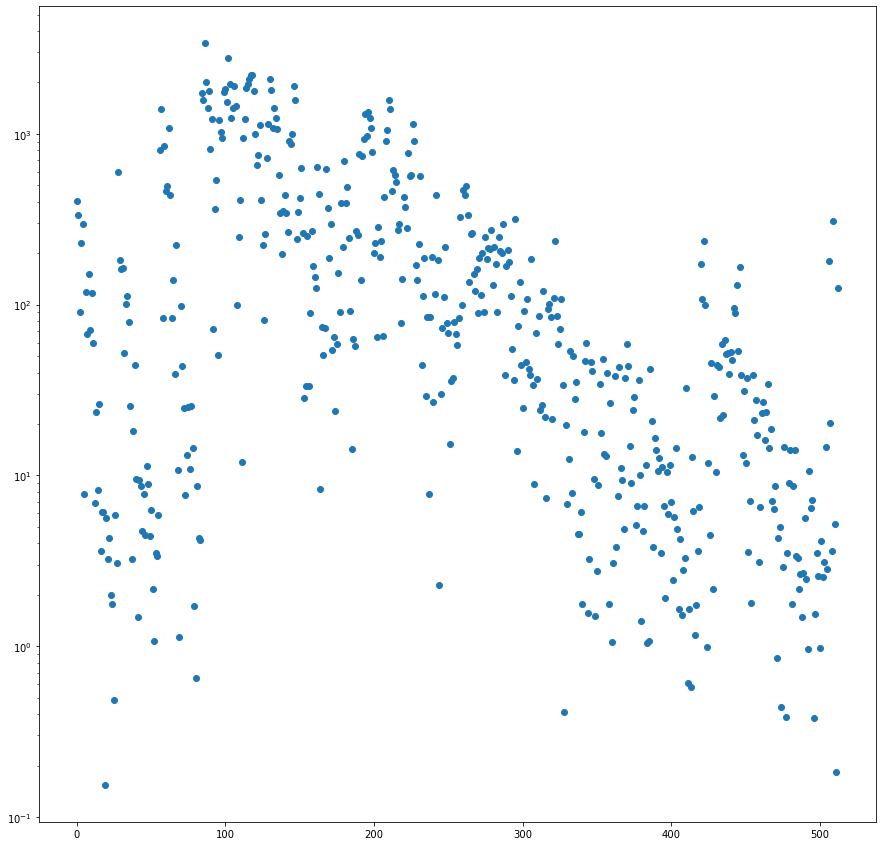

In [68]:
plt.figure(figsize=(15,15))
plt.scatter(range(513),np.abs(a[:,0]))
plt.yscale('log')


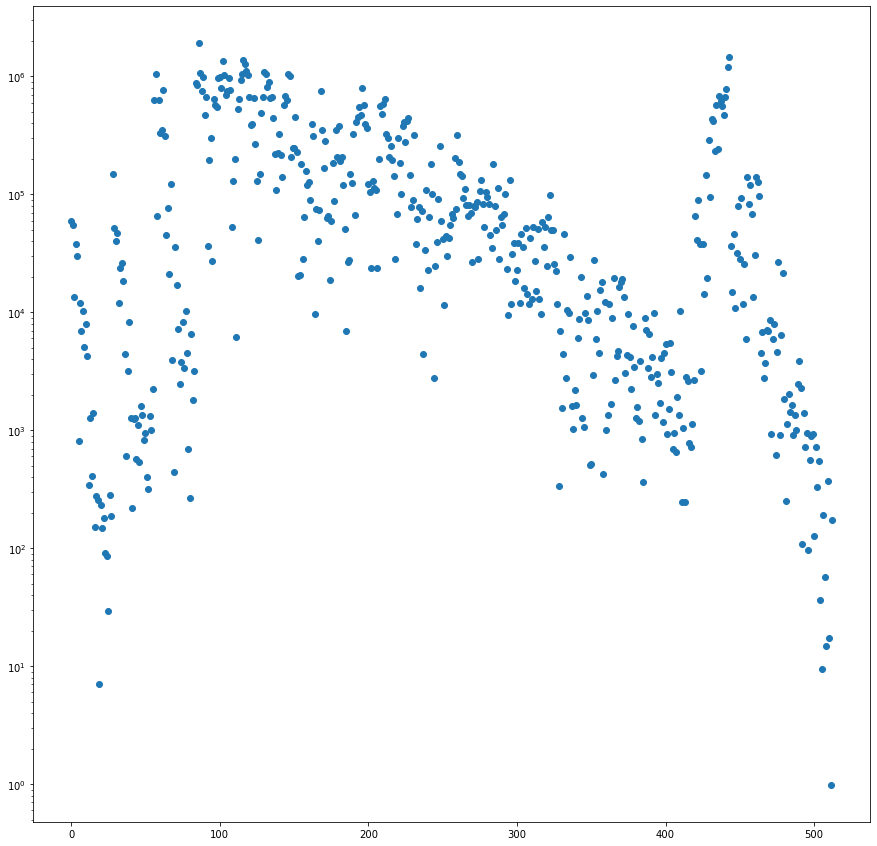

In [70]:
plt.figure(figsize=(15,15))
plt.scatter(range(513),np.abs(a[:,0])/np.abs(coef).mean(axis=0))
plt.yscale('log')

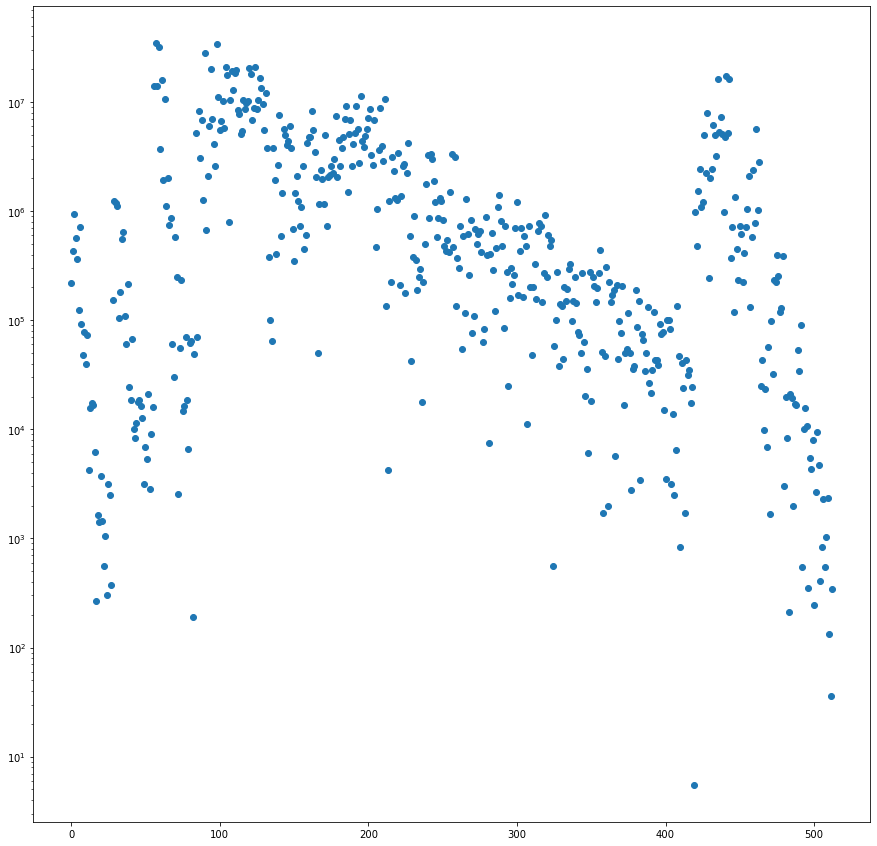

In [71]:
plt.figure(figsize=(15,15))
plt.scatter(range(513),np.abs(a[:,1])/np.abs(coef).mean(axis=0))
plt.yscale('log')

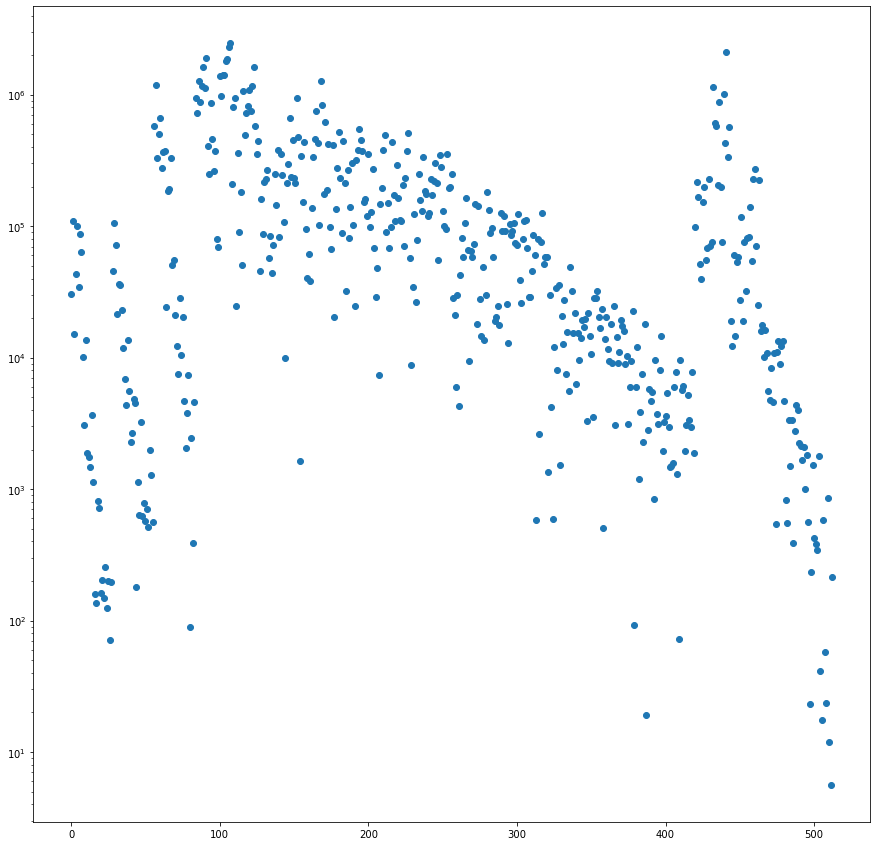

In [72]:
plt.figure(figsize=(15,15))
plt.scatter(range(513),np.abs(ga[:,0])/np.abs(gcoef_avg).mean(axis=0))
plt.yscale('log')

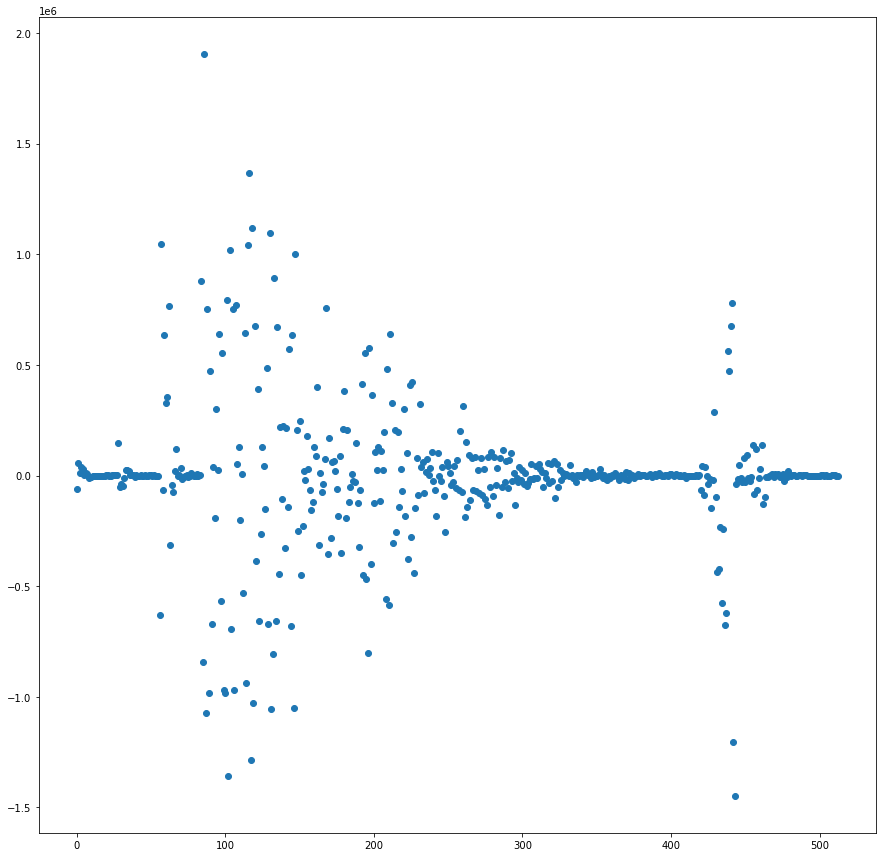

In [73]:
plt.figure(figsize=(15,15))
plt.scatter(range(513),a[:,0]/np.abs(coef).mean(axis=0))
#plt.yscale('log')

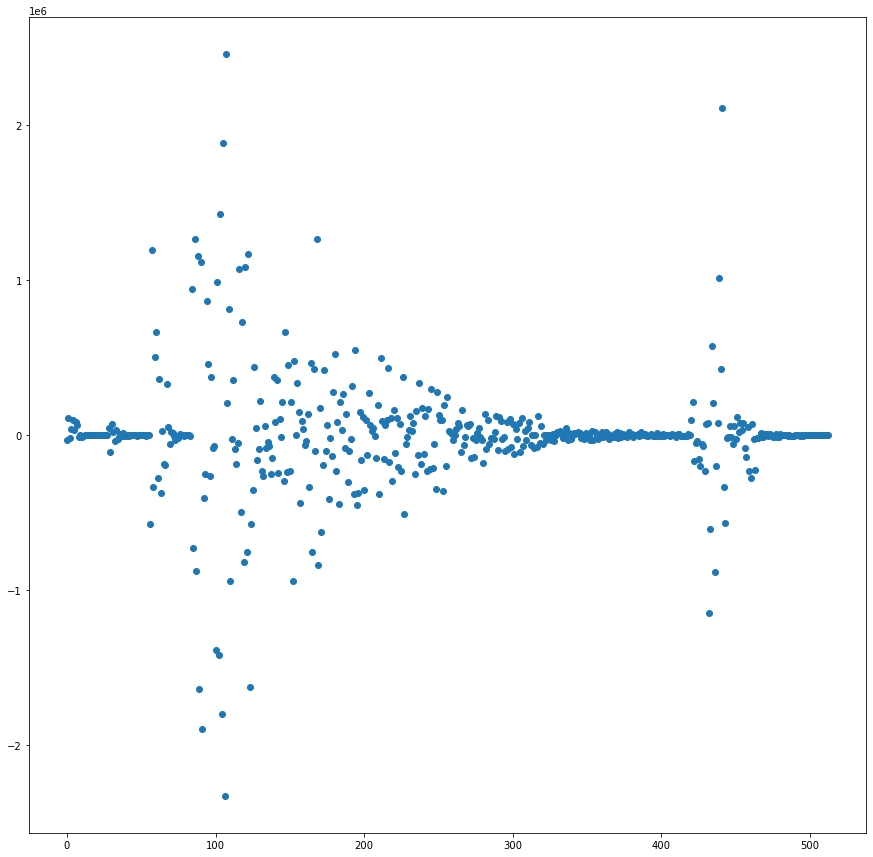

In [74]:
plt.figure(figsize=(15,15))
plt.scatter(range(513),ga[:,0]/np.abs(gcoef_avg).mean(axis=0))
#plt.yscale('log')

### Dataset

In [49]:
batch_size = 50
validation_split = .2
shuffle_dataset = True
random_seed = 4

# Creating data indices for training and validation splits:
y = torch.tensor(params,dtype=torch.float)
X = torch.tensor(np.c_[coef, coef**(1/2)],dtype=torch.float)
#y = torch.tensor(gparams,dtype=torch.float)
#X = torch.tensor(gcoef_avg,dtype=torch.float)
dataset      = data_utils.TensorDataset(X, y)
dataset_size = len(dataset)
indices      = list(range(dataset_size))
split        = int(np.floor(validation_split * dataset_size))
if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

### Construct CCA

In [50]:
a,b,u,v = CCA(X[train_indices,:],y[train_indices,:])

In [51]:
np.corrcoef(u[:,0],v[:,0])

array([[1.        , 0.99762338],
       [0.99762338, 1.        ]])

Relative error = tensor([13.8387,  4.4994], dtype=torch.float64) / R2 score = 0.8794442193057019


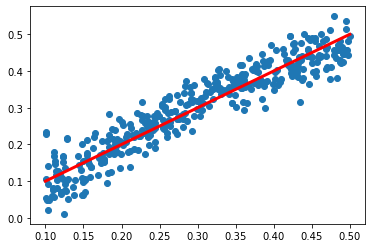

In [52]:
y_pred = np.matmul(np.matmul(X[val_indices,:],a),np.linalg.inv(b))
y_test = y[val_indices,:]
rel = np.abs(y_test-y_pred)/y_test *100
rel = rel.mean(axis=0)
r2  = sklearn.metrics.r2_score(y_test[:,0],y_pred[:,0])
print("Relative error = {} / R2 score = {}".format(rel,r2))
plt.scatter(y_test[:,0],y_pred[:,0])
ideal1 = np.linspace(0.1,0.5,3)
plt.plot(ideal1,ideal1,"r",lw=3)
plt.show()

## CCA to Hydro

In [4]:
coef = np.load("/mnt/home/yjo10/ceph/CAMELS/MIEST/data/wph_nIllustrisTNG_for_vib_total.npy")
gcoef_avg = np.zeros((1000, coef.shape[1]))
for i in range(1000):
    gcoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)
coef = np.load("/mnt/home/yjo10/ceph/CAMELS/MIEST/data/wph_nSIMBA_for_vib_total.npy")
rcoef_avg = np.zeros((1000, coef.shape[1]))
for i in range(1000):
    rcoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)
coef = np.load("/mnt/home/yjo10/ceph/CAMELS/MIEST/data/wph_nAstrid_for_vib_total.npy")
acoef_avg = np.zeros((1000, coef.shape[1]))
for i in range(1000):
    acoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)
coef = np.r_[gcoef_avg, rcoef_avg, acoef_avg]




fparam = '/mnt/home/fvillaescusa/CAMELS/PUBLIC_RELEASE/CMD/2D_maps/data/params_IllustrisTNG.txt'
gparams = np.loadtxt(fparam)
gparams = gparams[:,:2] ## only Om and Sig8
fparam = '/mnt/home/fvillaescusa/CAMELS/PUBLIC_RELEASE/CMD/2D_maps/data/params_SIMBA.txt'
rparams = np.loadtxt(fparam)
rparams = rparams[:,:2] ## only Om and Sig8
fparam = "/mnt/home/fvillaescusa/CAMELS/Results/images_Astrid/params_LH_Astrid.txt" 
aparams = np.loadtxt(fparam)
print(aparams.shape)
aparams = aparams[:,:2] ## only Om and Sig8
params  = np.r_[gparams, rparams, aparams]


/tmp/ipykernel_456863/694501691.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  gcoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)
/tmp/ipykernel_456863/694501691.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  rcoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)
/tmp/ipykernel_456863/694501691.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  acoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)


(1000, 6)


In [53]:
# Gadget
ga,gb,gu,gv = CCA(gcoef_avg,gparams)
# Ramses
ra,rb,ru,rv = CCA(rcoef_avg,rparams)
# Together 
a,b,u,v = CCA(coef,params)

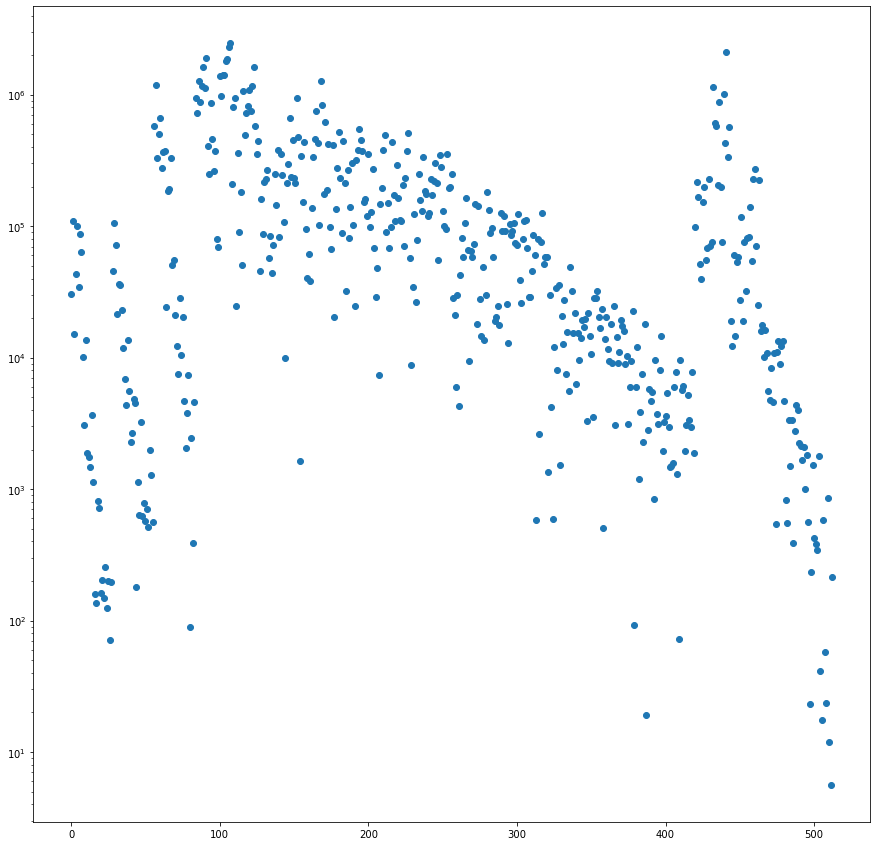

In [54]:
plt.figure(figsize=(15,15))
plt.scatter(range(513),np.abs(ga[:,0])/np.abs(gcoef_avg.mean(axis=0)))
plt.yscale('log')

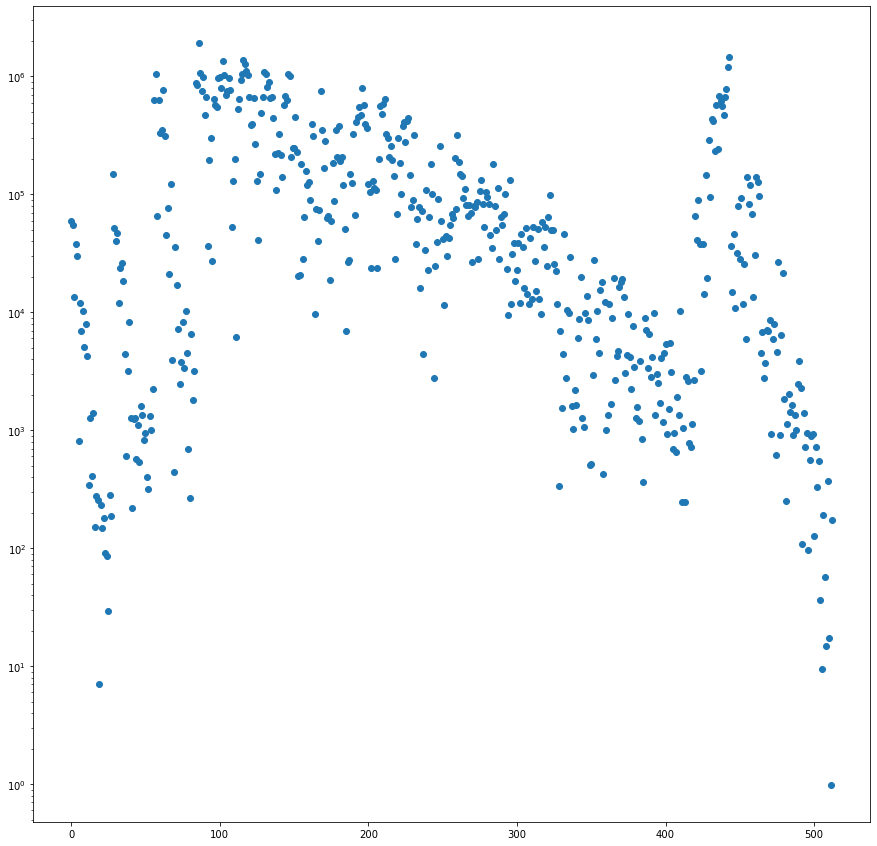

In [55]:
plt.figure(figsize=(15,15))
plt.scatter(range(513),np.abs(a[:,0])/np.abs(coef.mean(axis=0)))
plt.yscale('log')

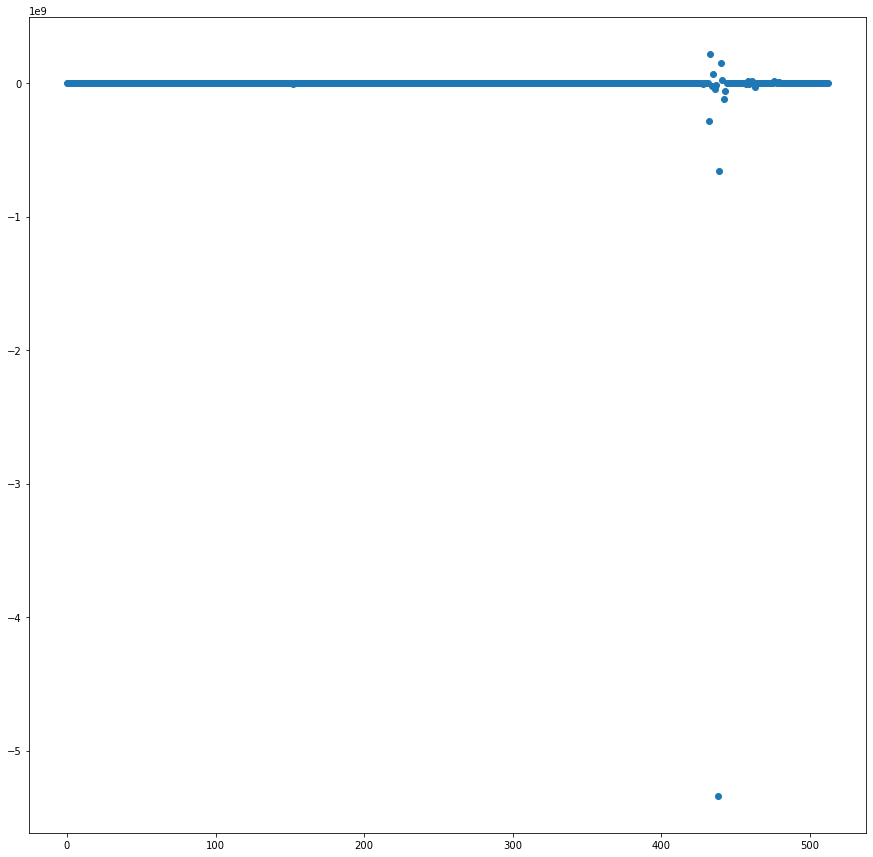

In [11]:
plt.figure(figsize=(15,15))
plt.scatter(range(513),ga[:,0]/gcoef_avg.mean(axis=0))
#plt.yscale('log')

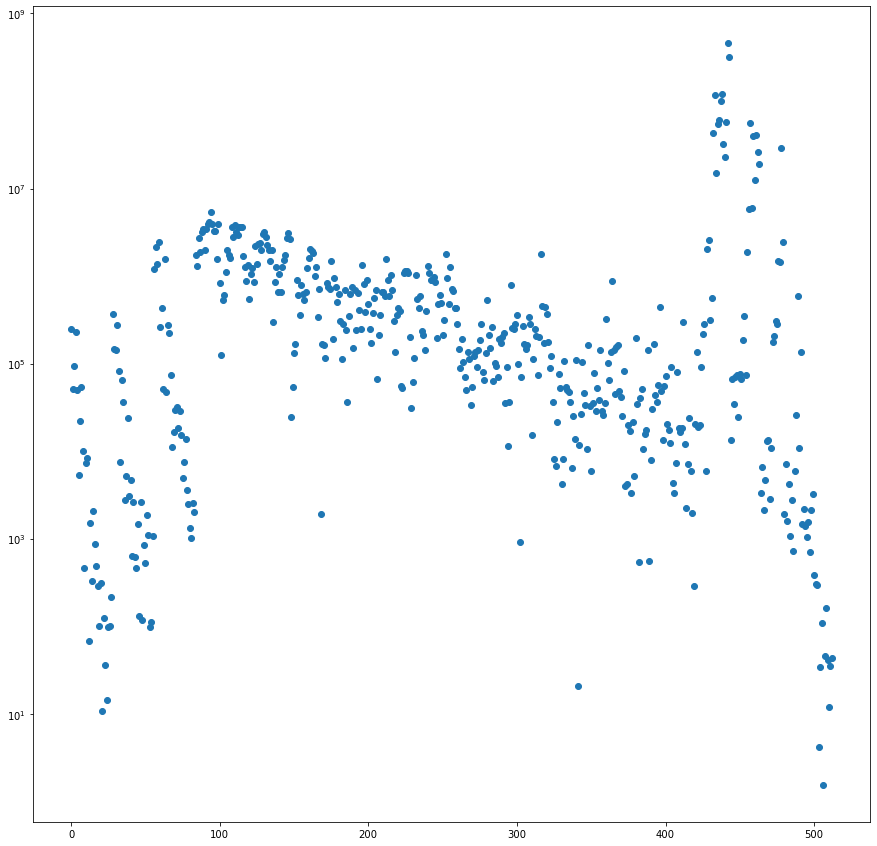

In [13]:
plt.figure(figsize=(15,15))
plt.scatter(range(513),np.abs(ra[:,0])/np.abs(rcoef_avg.mean(axis=0)))
plt.yscale('log')

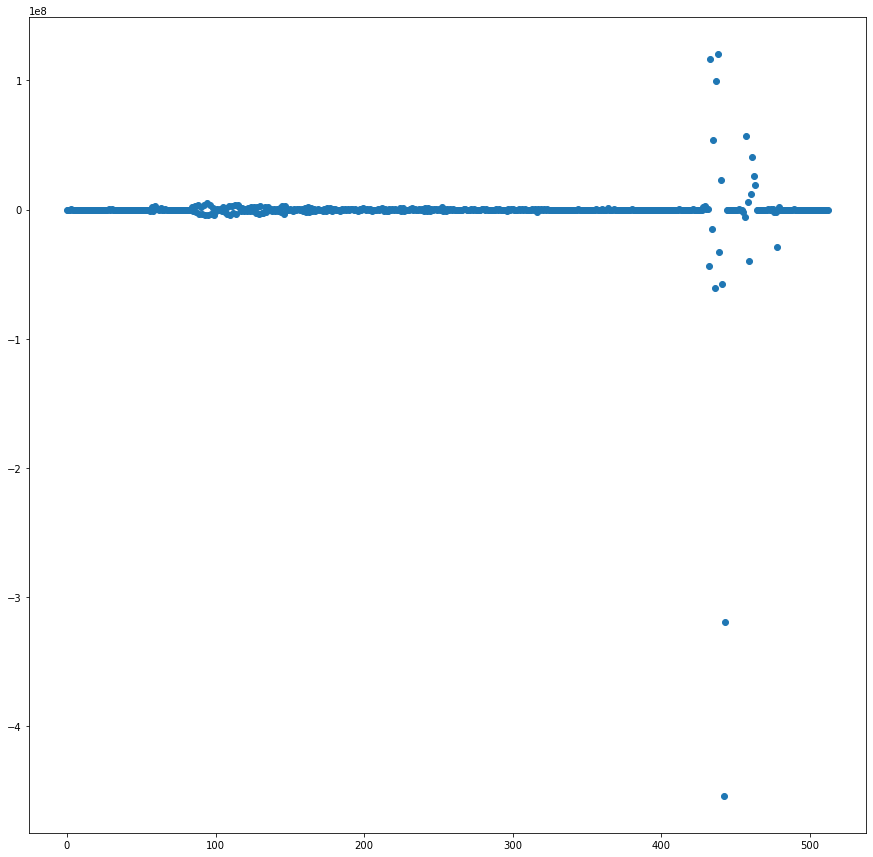

In [12]:
plt.figure(figsize=(15,15))
plt.scatter(range(513),ra[:,0]/rcoef_avg.mean(axis=0))
#plt.yscale('log')

## CCA test

In [ ]:
import pandas as pd
link2data = "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/penguins.csv"
df = pd.read_csv(link2data)
df =df.dropna()
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,MALE


In [ ]:
X = df[['bill_length_mm','bill_depth_mm']]
X.head()
X_mc = (X-X.mean())/(X.std())
Y = df[['flipper_length_mm','body_mass_g']]
Y_mc = (Y-Y.mean())/(Y.std())
Y.head()

,flipper_length_mm,body_mass_g
0,181.0,3750.0
1,186.0,3800.0
2,195.0,3250.0
4,193.0,3450.0
5,190.0,3650.0


In [ ]:
xmc=np.array(X_mc)
ymc=np.array(Y_mc)

x=np.array(X)
y=np.array(Y)

In [153]:
a,b,u,v=CCA(x,y)
np.matmul(u.T,v)

[0.00115405 0.01836134] [1.27802282e-05 2.06127452e-03]
(2, 2) (2,) (2, 2)
(2, 2) (2, 2)


array([[ 3.30896193e+02, -1.78649365e-12],
       [ 1.38505617e-12,  1.85031408e+02]])

In [151]:
a,b,u,v=CCA(xmc,ymc)
np.matmul(u.T,v)

[0.04951322 0.06248825] [0.04010186 0.15399018]
(2, 2) (2,) (2, 2)
(2, 2) (2, 2)


array([[2.61493663e+02, 2.07633344e-13],
       [1.72061113e-14, 2.86804663e+01]])

In [155]:
np.corrcoef(u[:,1],v[:,1])

array([[1.        , 0.55676664],
       [0.55676664, 1.        ]])

In [159]:
import numpy as np
def CCA(x, y, thres=1e-6):
    # x be (n,p1)
    # y be (n,p2)

    n, p1 = x.shape
    n, p2 = y.shape

    # SVD
    u1, s1, vt1 = np.linalg.svd(x ,full_matrices=False)
    u2, s2, vt2 = np.linalg.svd(y ,full_matrices=False)

    d1 = np.sum(s1 > thres) # d1 == p1 if x is non-degen
    d2 = np.sum(s2 > thres) # d2 == p2 if y is non-degen
    
    sinv1 = 1/s1
    sinv2 = 1/s2
    #print(sinv1, sinv2)

    xtotvar = np.sum(np.power(s1,2))
    ytotvar = np.sum(np.power(s2,2))

    q = np.matmul(u1.T[:d1,:], u2[:,:d2]) # maybe wrong
    
    uq, sq, vtq = np.linalg.svd(q,full_matrices=False)
    #print(uq.shape, sq.shape, vtq.shape)
    
    d = min(d1, d2)
    xccvar = np.matmul(np.eye(d1)*s1[:d1],u1[:d1,:d])/xtotvar
    yccvar = np.matmul(np.eye(d2)*s2[:d2].T,u2[:d2,:d])/ytotvar

    a = np.matmul(vt1.T[:p1,:d1],np.matmul(np.eye(d1)*sinv1,uq[:d1,:d]))
    b = np.matmul(vt2.T[:p2,:d2],np.matmul(np.eye(d2)*sinv2,vtq.T[:d2,:d]))
    #print(a.shape,b.shape)
    
    r = np.maximum(np.minimum(1,sq),0)
    xexplvar = xccvar * r**2
    yexplvar = yccvar * r**2

    # normalize a and b (do we need this?)
    a = a * np.sqrt(n-1)
    b = b * np.sqrt(n-1)

    u = np.matmul(x,a)
    v = np.matmul(y,b)
    
    return a, b, u, v